In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import copy

In [2]:
# Option
dave_mc=False

## Code to plot the impact from CO2 and climate separately
# Control - noclimate = Climate impact
# Control - noco2 = CO2 effect

# Open NCSCD as observation
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_0.5x0.5.nc'
#path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Background time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_1d'
respath_noco2='/data/jain1/d/sshu3/SBGC_1d_noco2'
respath_noclim='/data/jain1/d/sshu3/SBGC_1d_noclim'
flist = ['mean_bgc3d_1861_1870.nc', 'mean_bgc3d_1871_1880.nc', 'mean_bgc3d_1881_1890.nc', 'mean_bgc3d_1891_1900.nc', \
        'mean_bgc3d_1901_1910.nc', 'mean_bgc3d_1911_1920.nc', 'mean_bgc3d_1921_1930.nc', 'mean_bgc3d_1931_1940.nc', \
        'mean_bgc3d_1941_1950.nc', 'mean_bgc3d_1951_1960.nc', 'mean_bgc3d_1961_1970.nc', 'mean_bgc3d_1971_1980.nc', \
        'mean_bgc3d_1981_1990.nc', 'mean_bgc3d_1991_2000.nc', 'mean_bgc3d_2001_2010.nc']
flist_ctrl = flist
#['mean_bgc3d_1801_1810.nc', 'mean_bgc3d_1811_1820.nc', 'mean_bgc3d_1821_1830.nc', 'mean_bgc3d_1831_1840.nc', \
#        'mean_bgc3d_1841_1850.nc', 'mean_bgc3d_1851_1860.nc', 'mean_bgc3d_1861_1870.nc', 'mean_bgc3d_1871_1880.nc', \
#        'mean_bgc3d_1881_1890.nc', 'mean_bgc3d_1891_1900.nc', 'mean_bgc3d_1901_1910.nc', 'mean_bgc3d_1911_1920.nc', \
#        'mean_bgc3d_1921_1930.nc', 'mean_bgc3d_1931_1940.nc', 'mean_bgc3d_1941_1950.nc']

flen = len(flist)

soc_ctrl = np.zeros((flen, 360, 720))
soc_noclim = np.zeros((flen, 360, 720))
soc_noco2 = np.zeros((flen, 360, 720))

for i in np.arange(0,flen):
    # 0D
    print(flist[i])
    fp=respath_ctrl+'/'+flist_ctrl[i]
    nclu=NetCDFFile(fp,'r')
    #soc_temp_ctrl = nclu.variables['soil_c'][:]
    soclev_ctrl = nclu.variables['soil_c_lev'][:]
    resplev_ctrl = nclu.variables['resp_lev'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    fp=respath_noco2+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    #soc_temp_noco2 = nclu.variables['soil_c'][:]
    soclev_noco2 = nclu.variables['soil_c_lev'][:]
    resplev_noco2 = nclu.variables['resp_lev'][:]
    nclu.close()
    
    fp=respath_noclim+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    #soc_temp_noco2 = nclu.variables['soil_c'][:]
    soclev_noclim = nclu.variables['soil_c_lev'][:]
    resplev_noclim = nclu.variables['resp_lev'][:]
    nclu.close()

    # Get the topsoil SOC (0-30cm) from 1D model
    soc_top_ctrl = np.sum(soclev_ctrl[0:5,:,:], 0)
    soc_top_noco2 = np.sum(soclev_noco2[0:5,:,:], 0)
    soc_top_noclim = np.sum(soclev_noclim[0:5,:,:], 0)
    
    soc_sub_ctrl = np.sum(soclev_ctrl[5:7,:,:], 0)+0.3*soclev_ctrl[7,:,:]
    soc_sub_noco2 = np.sum(soclev_noco2[5:7,:,:], 0)+0.3*soclev_noco2[7,:,:]
    soc_sub_noclim = np.sum(soclev_noclim[5:7,:,:], 0)+0.3*soclev_noclim[7,:,:]
    
    soc_ctrl[i,:,:] = soc_top_ctrl + soc_sub_ctrl
    soc_noco2[i,:,:] = soc_top_noco2 + soc_sub_noco2
    soc_noclim[i,:,:] = soc_top_noclim + soc_sub_noclim

    #soc_ctrl[i,:,:] = soc_temp_ctrl
    #soc_noco2[i,:,:] = soc_temp_noco2
    

mean_bgc3d_1861_1870.nc
mean_bgc3d_1871_1880.nc
mean_bgc3d_1881_1890.nc
mean_bgc3d_1891_1900.nc
mean_bgc3d_1901_1910.nc
mean_bgc3d_1911_1920.nc
mean_bgc3d_1921_1930.nc
mean_bgc3d_1931_1940.nc
mean_bgc3d_1941_1950.nc
mean_bgc3d_1951_1960.nc
mean_bgc3d_1961_1970.nc
mean_bgc3d_1971_1980.nc
mean_bgc3d_1981_1990.nc
mean_bgc3d_1991_2000.nc
mean_bgc3d_2001_2010.nc


In [ ]:
a = [-2, -1, 0, 1, 2]

In [ ]:
len(np.where(a <0)[0])

In [3]:
# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent

# soc_ctrl_perm = copy.deepcopy(soc_ctrl)
# soc_noclim_perm = copy.deepcopy(soc_noclim)
# soc_noco2_perm = copy.deepcopy(soc_noco2)
# soc0d_ctrl_perm = copy.deepcopy(soc0d_ctrl)
# soc0d_noclim_perm = copy.deepcopy(soc0d_noclim)
# soc0d_noco2_perm = copy.deepcopy(soc0d_noco2)


# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

soc1d_ctrl_ts = np.zeros((flen))
soc1d_noco2_ts = np.zeros((flen))
soc1d_noclim_ts = np.zeros((flen))

for i in np.arange(0,flen):
    soc_ctrl_perm =  ma.masked_array(soc_ctrl[i,:,:], mask=another_mask.mask)
    soc_noco2_perm =  ma.masked_array(soc_noco2[i,:,:], mask=another_mask.mask)
    soc_noclim_perm =  ma.masked_array(soc_noclim[i,:,:], mask=another_mask.mask)
    # This condition is applied to filter out problematic outputs
    soc_ctrl_perm[soc_ctrl_perm<5] = np.float('nan')
    soc_noco2_perm[soc_noco2_perm<5] = np.float('nan')
    soc_noclim_perm[soc_noclim_perm<5] = np.float('nan')
    
    val_ctrl = soc_ctrl_perm * grid_area
    val_noco2 = soc_noco2_perm * grid_area
    val_noclim = soc_noclim_perm * grid_area
    
    soc1d_ctrl_ts[i] = np.nansum(val_ctrl)/1e12
    soc1d_noco2_ts[i] = np.nansum(val_noco2)/1e12
    soc1d_noclim_ts[i] = np.nansum(val_noclim)/1e12  

In [ ]:
# CO2 fertilize
co2_ts = soc1d_ctrl_ts - soc1d_noco2_ts
clim_ts = soc1d_ctrl_ts - soc1d_noclim_ts
co20d_ts = soc0d_ctrl_ts - soc0d_noco2_ts
clim0d_ts = soc0d_ctrl_ts - soc0d_noclim_ts

In [ ]:
soc1d_ctrl_ts[6:15] = soc1d_ctrl_ts[6:15] + 1.0

In [ ]:
soc1d_noco2_ts

In [ ]:
plt.plot(soc1d_noco2_ts - soc1d_ctrl_ts)
#plt.savefig('Climte_impact_of_0D_with_ST.png')

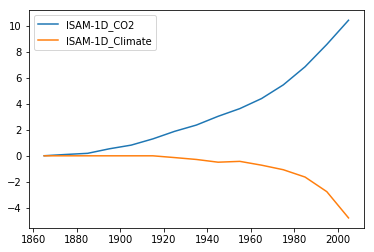

In [4]:
x = [1865, 1875, 1885, 1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995, 2005]
ddd= soc1d_noco2_ts - soc1d_ctrl_ts
plt.plot(x, (soc1d_noclim_ts - soc1d_ctrl_ts))
plt.plot(x, (soc1d_noco2_ts - soc1d_ctrl_ts))
plt.legend(['ISAM-1D_CO2', 'ISAM-1D_Climate'])
#plt.savefig('Climte_impact_of_0Dvs1D_with_ST.png')

In [6]:
soc1d_noclim_ts - soc1d_ctrl_ts

array([5.92557377e-03, 1.03090695e-01, 1.90863290e-01, 5.39954471e-01,
       8.20518439e-01, 1.30068506e+00, 1.88060346e+00, 2.36285176e+00,
       3.03537011e+00, 3.62763483e+00, 4.40071815e+00, 5.45202918e+00,
       6.84226768e+00, 8.55733113e+00, 1.04177988e+01])

In [ ]:
# Q10 = 2.8
# Ctrl: [344.85171623, 345.80078603, 346.34139048, 346.8789886 ,
#       347.29449594, 347.74482563, 348.09314122, 348.49433654,
#       348.81126034, 349.18891088, 349.25541638, 349.62803674,
#       349.92415567, 350.29038059, 350.58411073]
# Clim: [344.85217564, 345.80314492, 346.34677599, 346.88850015,
#       347.30917186, 347.76665129, 348.16312954, 348.49581482,
#       348.71102474, 348.98524177, 349.58879441, 350.12537981,
#       350.57307144, 350.65017399, 350.18227684]

# Q10 = 2.4
# Ctrl: [344.5191481 , 345.17887845, 345.52711288, 345.88347095,
#      346.14541027, 346.44376143, 346.66353591, 346.93265238,
#      347.13417957, 347.38880528, 347.57976805, 347.82852077,
#      348.01406415, 348.25970344, 348.4445406]
# Clim: [344.519099  , 345.17987016, 345.53062931, 345.89146083,
#      346.15937421, 346.46507588, 346.73136806, 346.92971148,
#      347.04432112, 347.27269269, 347.76228432, 348.1712788 ,
#      348.5172708 , 348.55997683, 348.13510629]

# Q10 = 1.2
# Ctrl: [341.51694308, 340.48405846, 339.85080782, 339.27679125,
#       338.73511078, 338.22844317, 337.74321153, 337.28312744,
#       336.83653628, 336.41005896, 335.99370333, 335.59304902,
#       335.19949298, 334.81906357, 334.44468435]
# Clim: [341.5174404 , 340.48600423, 339.8548834 , 339.28282276,
#       338.74641193, 338.24610884, 337.79399739, 337.25823478,
#       336.74287354, 336.63611049, 336.60005962, 336.42417635,
#       336.28864333, 336.06231038, 335.65362332]

# Q10 = 1.5
# Ctrl: [342.73772848, 342.28319669, 342.00721199, 341.78753358,
#       341.56793389, 341.38590018, 341.19095113, 341.0281154 ,
#       340.8518669 , 340.70464122, 340.54095463, 340.40364745,
#       340.24788014, 340.11891742, 339.97153639]
# Clim: [342.73751558, 342.28385905, 342.01053194, 341.7929937 ,
#       341.57737078, 341.40072236, 341.24679267, 341.01674135,
#       340.78221579, 340.84982315, 341.00768284, 341.04366537,
#       341.09716929, 341.00718581, 340.65119725]


In [ ]:
all_ts

In [ ]:
all0d_ts

In [ ]:
co2_ts = all_ts - clim_ts

In [ ]:
co20d_ts = all0d_ts - clim0d_ts

In [ ]:
clim_ts

In [ ]:
clim0d_ts/3

In [ ]:
co2_ts = all_ts - clim_ts
co20d_ts = all0d_ts - clim0d_ts

In [ ]:
# Make plot of the time series
fig = plt.figure(figsize=(10,8))
x = [1865, 1875, 1885, 1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995, 2005]
plt.plot(x, clim0d_ts, linestyle='--', color='red')
plt.plot(x, clim_ts, linestyle='-', color='red')
plt.plot(x, co20d_ts, linestyle='--', color='green')
plt.plot(x, co2_ts, linestyle='-', color='green')
plt.plot(x, all0d_ts, linestyle='--', color='blue')
plt.plot(x, all_ts, linestyle='-', color='blue')
plt.axhline(linewidth=2, linestyle=':', color='gray')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Change of SOCS (PgC)', fontsize=20)
plt.legend(['Climate - ISAM0D', 'Climate - ISAM1D', 'CO2 - ISAM0D', 'CO2 - ISAM1D', 'Total - ISAM0D', 'Total - ISAM1D'], fontsize=20)
plt.savefig('./figures/fig12.png')

In [ ]:
soc1d_ctrl_ts

In [ ]:
soc1d_noclim_ts

In [ ]:
soc1d_noco2_ts

In [ ]:
soc0d_ctrl_ts

In [ ]:
soc0d_noclim_ts

In [ ]:
soc0d_ctrl_ts

In [ ]:
# ISAM-1D control 2000s ...
# 353.52246987372865
# ISAM-1D noclim 2000s ...
# 353.54943063669714
# ISAM-1D noco2 2000s ...
# 344.8873073819888
# ISAM-1D 1860s ...
# 343.61655160412346

# ISAM-0D control 2000s ...
# 180.7218003115083
# ISAM-0D noclim 2000s ...
# 183.71581733148145
# ISAM-0D noco2 2000s ...
# 173.77598900823125
# ISAM-0D control 1860s ...
# 177.30753527613672

In [ ]:
# Clim-1D: -1.0
# CO2-1D: 10.9
# Clim-1D: -3.6
# CO2-1D: 6.6

In [ ]:
soc_contemp_perm = copy.deepcopy(soc_contemp)

In [ ]:
plt.imshow(dsoc)

In [ ]:
# Mask all regions outside the northern permafrost extent
# Control
dsoc_perm = copy.deepcopy(dsoc)
dsoc_perm.mask = another_mask.mask
dsoc0d_perm = copy.deepcopy(dsoc0d)
dsoc0d_perm.mask = another_mask.mask
# No Climate
dsoc_noclim_perm = copy.deepcopy(dsoc_noclim)
dsoc_noclim_perm.mask = another_mask.mask
dsoc0d_noclim_perm = copy.deepcopy(dsoc0d_noclim)
dsoc0d_noclim_perm.mask = another_mask.mask
# No CO2
dsoc_noco2_perm = copy.deepcopy(dsoc_noco2)
dsoc_noco2_perm.mask = another_mask.mask
dsoc0d_noco2_perm = copy.deepcopy(dsoc0d_noco2)
dsoc0d_noco2_perm.mask = another_mask.mask

## Get into the story of tau later
# dtau_perm = copy.deepcopy(dtau)
# dtau_perm.mask = another_mask.mask
# dtau0d_perm = copy.deepcopy(dtau0d)
# dtau0d_perm.mask = another_mask.mask

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,24))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM-0D change of SOC stock by CO2 fertilization (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,dsoc0d_perm[:,:] - dsoc0d_noco2_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
cbar = map.colorbar(cs1,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM-1D change of SOC stock by CO2 fertilization (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,dsoc_perm[:,:] - dsoc_noco2_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs2,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 


ax3 = fig.add_subplot(223)
ax3.set_title("ISAM-1D change of SOC stock by Climate (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dsoc0d_perm[:,:] - dsoc0d_noclim_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs3,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM-0D change of SOC stock by Climate (2000s - 1860s)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dsoc_perm[:,:] - dsoc_noclim_perm[:,:],
              norm=colors.Normalize(vmin=-1.,vmax=1.),cmap=plt.cm.bwr) # use log color scale,
#              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,

cbar = map.colorbar(cs4,ticks=[-1, -0.5, 0, 0.5, 1],location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

#plt.show()
plt.savefig('./figures/fig10.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.bwr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

plt.show()
#plt.savefig('./figures/fig8.png',dpi=300)

In [ ]:
# Plot the figure3
# Mask all regions outside the northern permafrost extent
resp_contemp_perm = copy.deepcopy(resp_contemp)
resp_contemp_perm.mask = another_mask.mask
resp0d_contemp_perm = copy.deepcopy(resp0d_contemp)
resp0d_contemp_perm.mask = another_mask.mask
resp_preind_perm = copy.deepcopy(resp_preind)
resp_preind_perm.mask = another_mask.mask
resp0d_preind_perm = copy.deepcopy(resp0d_preind)
resp0d_preind_perm.mask = another_mask.mask
dresp_perm = copy.deepcopy(dresp)
dresp_perm.mask = another_mask.mask
dresp0d_perm = copy.deepcopy(dresp0d)
dresp0d_perm.mask = another_mask.mask

# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig9.jpg',dpi=300)

In [ ]:
lonnc2

In [ ]:
lonnc2 % 360
